In [1]:
# Step 0: Importing Required Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Optional: For visualizing correlations or distributions
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Step 1: Load the dataset
df = pd.read_csv('players_data.csv')

# Display first few rows to confirm
df.head()


,userNum,nickname,gameId,seasonId,gameRank,character,weapon,itemWeapon,itemChest,itemHead,...,Trait_Main1,Trait_Main2,Trait_Sub1,Trait_Sub2,TeamKill,Kill,Death,Assist,Dmg_Player,Dmg_Monster
0,5426009,마샤,46678118,31,2,Cathy,Dagger,Asura,The_Revenant,Imperial_Crown,...,Unwavering_Mentality,Cavalcade,Coin_Toss,Penny_Pincher,5,0,3,5,12065,53392
1,5296453,쿠로미여동생,46678118,31,1,Hisui,Two-handed_Sword,Aurora_Longsword,Áo_Dài,Blaster_Helmet,...,Contempt_for_the_Weak,Anima_Reaper,Unwavering_Mentality,Cavalcade,17,5,4,7,15397,79563
2,5162955,우주생명마음,46678118,31,5,Adina,Arcana,The_Moon,Blood_Cloak,Persona,...,Open_Wounds,Overwatch,Dismantle_Goliath,Anima_Reaper,19,12,2,6,36449,67664
3,5140049,只玩过卡拉彼丘,46678118,31,7,Ly Anh,Dagger,Maharaja,Dragon_Dobok,Cowboy_Hat,...,Frenzy,Carnivore,Painkiller,Dine_n'_Dash,10,0,3,6,6315,23338
4,5051669,초고교급마다키,46678118,31,7,Tsubame,Shuriken,Petal_Torrent,Changpao,Crystal_Tiara,...,Dismantle_Goliath,Anima_Reaper,Unwavering_Mentality,Cavalcade,10,9,2,0,17556,50226


In [3]:
# Step 3: Handle missing values
missing_ratio = df.isnull().mean().sort_values(ascending=False)
print("Missing values (top 10):\n", missing_ratio.head(10))

# Drop rows where key performance metrics are missing (gameRank, Dmg_Player, etc.)
df.dropna(subset=['gameRank', 'Dmg_Player', 'Dmg_Monster'], inplace=True)


Missing values (top 10):
 Trait_Main2    0.086473
Trait_Main1    0.086473
Trait_Sub2     0.002084
Trait_Sub1     0.000564
userNum        0.000000
nickname       0.000000
Dmg_Player     0.000000
Assist         0.000000
Death          0.000000
Kill           0.000000
dtype: float64


In [5]:
# Step 4: Feature Engineering (fixed)

# Fill missing trait values with 'Unknown' and ensure everything is a string
df[['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']] = (
    df[['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']]
    .fillna('Unknown')
    .astype(str)
)

#combine the traits into one string
df['AllTraits'] = df[['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']].agg('_'.join, axis=1)

# Bin gameRank into performance tiers
def rank_to_tier(rank):
    if rank <= 3:
        return 'Good'
    elif rank <= 6:
        return 'Average'
    else:
        return 'Bad'

df['BuildPerformance'] = df['gameRank'].apply(rank_to_tier)


In [6]:
# Step 5: Define input features and target

# Features we'll use:
categorical_features = ['character', 'weapon', 'itemWeapon', 'itemChest', 'itemHead',
                        'itemArm', 'itemLeg', 'AllTraits']
numerical_features = ['Kill', 'Assist', 'Death', 'TeamKill', 'Dmg_Player', 'Dmg_Monster']

# Target: BuildPerformance (Good/Average/Bad)
target = 'BuildPerformance'


In [7]:
# Step 6: Split dataset
X = df[categorical_features + numerical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:
# Step 7: Build Preprocessing Pipeline

# Categorical pipeline: Fill missing with 'Unknown', then one-hot encode
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Numerical pipeline: Fill missing with median, then scale
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine both pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_features),
    ('num', numerical_pipeline, numerical_features)
])


In [9]:
# Step 8: Final pipeline with classifier

model_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [10]:
# Step 9: Train the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['character', 'weapon',
                                                   'itemWeapon', 'itemChest',
                                                   'itemHead', 'itemArm',
                                                   'itemLeg', 'AllTraits']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Kill', 'Assist', 'Death',
                                                   'TeamKill', 'Dmg_Player',
                                                   'Dmg_Monster'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Classification Report:

              precision    recall  f1-score   support

     Average       0.59      0.64      0.61      1617
         Bad       0.67      0.57      0.61       929
        Good       0.83      0.83      0.83      2062

    accuracy                           0.71      4608
   macro avg       0.69      0.68      0.68      4608
weighted avg       0.71      0.71      0.71      4608

Confusion Matrix:



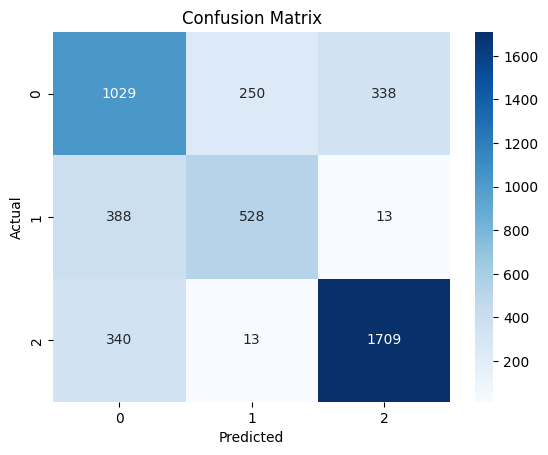

In [11]:
# Step 10: Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model_pipeline.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Predicted Average (0)	Predicted Bad (1)	Predicted Good (2)
Actual Avg (0) 1029	250	338
Actual Bad (1)	388	528	13
Actual Good (2)	340	13	1709

In [ ]:
def get_recommended_build(character_name, top_n=1, display=True):
    """
    Recommends a build for a given character based on top-performing matches.
    
    Parameters:
        character_name (str): Character name (e.g., "Cathy")
        top_n (int): Number of builds to return
        display (bool): If True, print builds nicely

    Returns:
        List of dictionaries containing the builds
    """
    char_data = df[df['character'] == character_name]

    if char_data.empty:
        print(f"No data found for character: {character_name}")
        return []

    top_builds = char_data[char_data['gameRank'] <= 3]

    if top_builds.empty:
        print(f"No high-performing builds found for {character_name}. Showing best available instead.")
        top_builds = char_data.sort_values(by='gameRank', ascending=True).head(top_n)
    else:
        top_builds = top_builds.sort_values(by='gameRank', ascending=True).head(top_n)

    builds = []
    for idx, (_, row) in enumerate(top_builds.iterrows(), start=1):
        build = {
            "Weapon": row['weapon'],
            "ItemWeapon": row['itemWeapon'],
            "ItemChest": row['itemChest'],
            "ItemHead": row['itemHead'],
            "ItemArm": row['itemArm'],
            "ItemLeg": row['itemLeg'],
            "Traits": [row['Trait_Main1'], row['Trait_Main2'], row['Trait_Sub1'], row['Trait_Sub2']]
        }
        builds.append(build)

        if display:
            print(f"\nRecommended Build #{idx} for {character_name}:")
            print(f"Weapon      : {build['Weapon']}")
            print(f"ItemWeapon  : {build['ItemWeapon']}")
            print(f"ItemChest   : {build['ItemChest']}")
            print(f"ItemHead    : {build['ItemHead']}")
            print(f"ItemArm     : {build['ItemArm']}")
            print(f"ItemLeg     : {build['ItemLeg']}")
            print("Traits      : " + ", ".join(build['Traits']))


In [ ]:
get_recommended_build("Cathy", top_n=3)



Recommended Build #1 for Cathy:
Weapon      : Dagger
ItemWeapon  : Scarlet_Dagger_-_Dawn
ItemChest   : Kabana
ItemHead    : Cyberstalker
ItemArm     : Nova_Shield
ItemLeg     : Rose_Steps
Traits      : Coin_Toss, Penny_Pincher, Stopping_Power, Overwatch

Recommended Build #2 for Cathy:
Weapon      : Dagger
ItemWeapon  : Scarlet_Dagger_-_Dawn
ItemChest   : Holy_Orders
ItemHead    : Cyberstalker
ItemArm     : Dragon_Scale
ItemLeg     : Killer_Heels
Traits      : Unknown, Unknown, 7N39, Thorn_Shackles

Recommended Build #3 for Cathy:
Weapon      : Dagger
ItemWeapon  : Phantom_Blade
ItemChest   : Holy_Orders
ItemHead    : Viking_Helmet
ItemArm     : Tellurian_Timepiece
ItemLeg     : Red_Shoes
Traits      : Unknown, Unknown, Omnipotence, Scar_Ripper
